# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

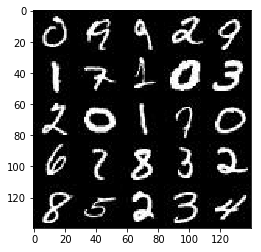

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

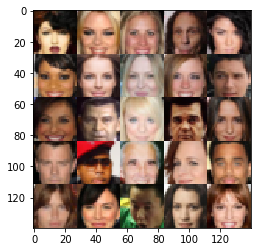

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    #Variable 노드는 다른 언어의 Variable과 달리, 실행 시 텐서플로우가 변경시키는 값이라고 생각하면 이해하기 편하다.(학습하는 과정에서 변경시킨다.)
    #tf.placeholder()는 입력 데이터를 만들 때 주로 사용한다. (실제 훈련 예제를 제공하는 변수) - 초기값을 지정할 필요 없다. (모델 입력시 변경되지 않을 데이터)
    #tf.Variable()은 데이터의 상태를 저장할 때 주로 사용한다. (가중치나 편향 등의 학습 가능한 변수) - 초기값을 지정해야 한다. (학습 되는 데이터)
    #http://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Leaky ReLU

In [6]:
def leaky_relu(x, alpha=0.01): #leaky_relu. x는 텐서. 
        return tf.maximum(alpha * x, x)
        #Leaky ReLU는 마이너스 입력일 경우 0이 아닌 입력 절대값에 비례한 작은 값을 리턴한다.
        #Leaky ReLU를 지원하지 않기 때문에 직접 만들어야 한다. 음수 값 입력에선 alpha *x, 양수 값 입력에선 x 반환

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse): #공유 변수
    #tf.variable_scope : 공유 변수. 공유 변수를 사용하지 않으면 학습된 변수가 아닌 계속해서 새로운 변수를 생성하게 된다.
    #tf.variable_scope에 reuse 키워드를 사용하여 그래프를 다시 작성하는 경우 새 변수를 작성하는 대신 변수를 재사용하도록 지시 할 수 있다.
    
        # Input layer is 28x28x3 : 28x28 dimensional images. RGB
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same') #CNN
        relu1 = leaky_relu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        # 4x4x256
        
        #tf.layers.batch_normalization : 배치 사용 (인풋). training는 optional. 현재 학습인지 테스트인지 bool로.
        #GAN 정확도를 높이기 위해 Batch Normalization를 사용한다. discriminator가 한 번에 여러 샘플을 보도록 Batch Normalization 사용.
        ##Batch Normalization : 각 layer의 input을 normailze하여, distribution을 일정하게 유지시키려는 시도.
        #https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        
        #tf.layers.conv2d : CNN 생성. (inputs, filters, kernel_size)
        #https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
        #kernel_initializer=tf.contrib.layers.xavier_initializer()를 사용해 커널을 초기화하면 더 정확한 결과를 얻을 수 있다.

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256)) #FC input으로 사용하기 위해 reshape
        logits = tf.layers.dense(flat, 1) #FC
        out = tf.sigmoid(logits) #활성함수 sigmoid
        
        #tf.layers.dense : Functional interface for the densely-connected layer.
        #tf.layers.dense를 사용하면 간단하게 신경망을 만들 수 있다. 파라미터는 (인풋, 출력 차원(아웃풋 사이즈)). 나머지는 모두 optional. Relu를 활성화함수로 FC
        #https://www.tensorflow.org/api_docs/python/tf/layers/dense
        
        #이전 mnist에서 만든 discriminator 비슷하지만 더 깊고, Batch Normalization 사용

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train): #공유 변수
    #tf.variable_scope : 공유 변수. 공유 변수를 사용하지 않으면 학습된 변수가 아닌 계속해서 새로운 변수를 생성하게 된다.
    #tf.variable_scope에 reuse 키워드를 사용하여 그래프를 다시 작성하는 경우 새 변수를 작성하는 대신 변수를 재사용하도록 지시 할 수 있다.
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512) #인풋: 노이즈 벡터, 출력 사이즈 : 7*7*512 #FC
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) #CNN 인풋에 맞도록 reshape
        x1 = tf.layers.batch_normalization(x1, training=is_train) #Batch Normalization
        x1 = leaky_relu(x1) #Leaky ReLU activation. 활성 함수로 leaky ReLU 사용.
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        #inputs, filters, kernel_size
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 28x28x128 now
        
        #tf.layers.dense : Functional interface for the densely-connected layer.
        #tf.layers.dense를 사용하면 간단하게 신경망을 만들 수 있다. 파라미터는 (인풋, 출력 차원(아웃풋 사이즈)). 나머지는 모두 optional. Relu를 활성화함수로 FC
        #https://www.tensorflow.org/api_docs/python/tf/layers/dense
        
        #tf.layers.batch_normalization : 배치 사용 (인풋). training는 optional. 현재 학습인지 테스트인지 bool로.
        #GAN 정확도를 높이기 위해 Batch Normalization를 사용한다. discriminator가 한 번에 여러 샘플을 보도록 Batch Normalization 사용.
        ##Batch Normalization : 각 layer의 input을 normailze하여, distribution을 일정하게 유지시키려는 시도.
        #https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        
        #tf.layers.conv2d_transpose : 전치된 CNN 생성. (일반 CNN과 반대) (inputs, filters, kernel_size)
        #https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose
        #kernel_initializer=tf.contrib.layers.xavier_initializer()를 사용해 커널을 초기화하면 더 정확한 결과를 얻을 수 있다.
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same') #CNN
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits) #마지막 활성 함수는 tanh. 28x28 (image 크기)
        #tanh는 -1과 1사이의 값을 리턴 cf. sigmoid : 0 ~ 1사이의 값
        
        #이전 mnist에서 만든 generator와 비슷하지만 더 깊고, Batch Normalization 사용
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True) #이미지 생성
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) #실제 이미지
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) #생성된 이미지

    d_loss_real = tf.reduce_mean( #식별기 실제 이미지 손실
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    #1로 판별해야 하므로 tf.one_like 사용 : 1을 출력하기를 원함
    #Discriminator의 일반화를 돕기 위해 매개 변수 smooth를 사용하여 레이블을 1.0에서 0.9로 약간 줄인다. 
    #일반적으로 성능 향상을 위해 Discriminator와 함께 사용되는 label smoothing이라고 한다.
    
    d_loss_fake = tf.reduce_mean( #식별기 생성 이미지 손실
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #0으로 판별해야 하므로 tf.zeros_like 사용 : 0을 출력하기를 원함 (Generator로 생성된 것을 가짜로 판별하는 것이 Discriminator의 목적)
    #d_loss_real과 비슷하지만 smoothing이 적용되지 않았다
    
    g_loss = tf.reduce_mean( #생성기 손실
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    #1로 판별해야 하므로 tf.one_like 사용 : 1을 출력하기를 원함 (Discriminator를 속이는 것이 Generator의 목적)

    d_loss = d_loss_real + d_loss_fake #식별기의 손실은 실제 이미지 손실과 생성된 이미지 손실의 합
    #Discriminator의 총 손실은 실제 데이터 손실과 생성 데이터 손실의 합

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables() #학습된 변수들을 불러 온다. 
    #trainable=True로 만든 모든 변수 반환
    #https://www.tensorflow.org/api_docs/python/tf/trainable_variables
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")] #generator에서 만든 변수 뽑아내 저장
    g_vars = [var for var in t_vars if var.name.startswith("generator")] #discriminator에서 만든 변수 뽑아내 저장

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): #의존성 지정. 컨텍스트 정의 전 실행되거나 계산되어야 할 목록
        #'tf.control_dependencies'문맥은 TensorFlow에게 'tf.nn.batch_normalization'계층을 계산하기 전에 
        #'train_mean'과 'train_variance'를 계산해야한다고 알려준다. 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        #Adam으로 최적화. var_list로 넘어온 변수들만 최적화한다.

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #data_shape[0] : count
    #data_shape[1] : width
    #data_shape[2] : height
    #data_shape[3] : channels
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) #초기화
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
#                 batch_images = batch_images * 2 # normalization
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) #생성기에 노이즈 추가. 랜덤 노이즈에서 이미지 생성
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                                
                if steps % 10 == 0: #10번 마다 출력 
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0: #100번 마다 이미지 출력             
                    show_generator_output(sess, n_images=25, input_z=input_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)
                
                steps += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 11.0609... Generator Loss: 0.0001


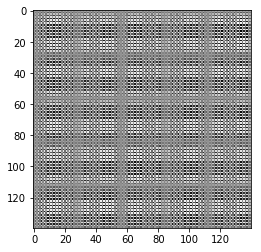

Epoch 1/2... Discriminator Loss: 1.4448... Generator Loss: 14.2639
Epoch 1/2... Discriminator Loss: 0.3458... Generator Loss: 6.1610
Epoch 1/2... Discriminator Loss: 0.3458... Generator Loss: 5.4212
Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 5.4458
Epoch 1/2... Discriminator Loss: 0.4143... Generator Loss: 3.2727
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 2.8343
Epoch 1/2... Discriminator Loss: 0.3547... Generator Loss: 5.5665
Epoch 1/2... Discriminator Loss: 0.3369... Generator Loss: 5.4465
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 6.5271
Epoch 1/2... Discriminator Loss: 0.3336... Generator Loss: 6.1494


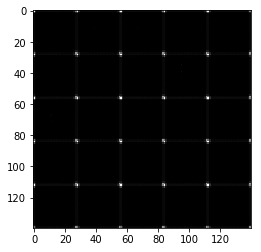

Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 6.6081
Epoch 1/2... Discriminator Loss: 0.3312... Generator Loss: 6.4396
Epoch 1/2... Discriminator Loss: 0.3296... Generator Loss: 7.0814
Epoch 1/2... Discriminator Loss: 0.3312... Generator Loss: 6.4229
Epoch 1/2... Discriminator Loss: 0.3352... Generator Loss: 6.5462
Epoch 1/2... Discriminator Loss: 0.3328... Generator Loss: 6.4037
Epoch 1/2... Discriminator Loss: 0.3298... Generator Loss: 7.2259
Epoch 1/2... Discriminator Loss: 0.3281... Generator Loss: 6.9329
Epoch 1/2... Discriminator Loss: 0.3285... Generator Loss: 7.2878
Epoch 1/2... Discriminator Loss: 0.3276... Generator Loss: 7.6136


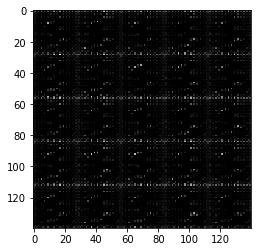

Epoch 1/2... Discriminator Loss: 0.3307... Generator Loss: 5.6109
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.4924
Epoch 1/2... Discriminator Loss: 0.5350... Generator Loss: 2.0666
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.9603
Epoch 1/2... Discriminator Loss: 0.3753... Generator Loss: 3.8174
Epoch 1/2... Discriminator Loss: 0.3478... Generator Loss: 5.3058
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 4.6716
Epoch 1/2... Discriminator Loss: 0.6250... Generator Loss: 2.3093
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 3.7694
Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 0.8773


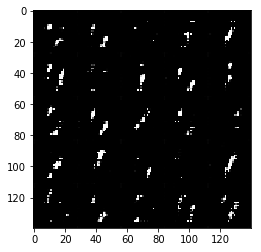

Epoch 1/2... Discriminator Loss: 0.4580... Generator Loss: 3.2188
Epoch 1/2... Discriminator Loss: 0.3811... Generator Loss: 3.7089
Epoch 1/2... Discriminator Loss: 0.5031... Generator Loss: 3.0759
Epoch 1/2... Discriminator Loss: 0.3867... Generator Loss: 3.4060
Epoch 1/2... Discriminator Loss: 0.4089... Generator Loss: 3.0012
Epoch 1/2... Discriminator Loss: 0.3463... Generator Loss: 5.1523
Epoch 1/2... Discriminator Loss: 0.3424... Generator Loss: 4.8454
Epoch 1/2... Discriminator Loss: 0.3472... Generator Loss: 9.2441
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 4.8272
Epoch 1/2... Discriminator Loss: 0.3495... Generator Loss: 5.5281


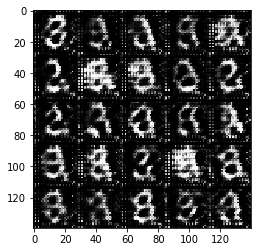

Epoch 1/2... Discriminator Loss: 0.3562... Generator Loss: 4.1045
Epoch 1/2... Discriminator Loss: 1.8192... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.6280... Generator Loss: 2.2609
Epoch 1/2... Discriminator Loss: 0.4172... Generator Loss: 4.3779
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 3.9145
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 2.0852
Epoch 1/2... Discriminator Loss: 0.3651... Generator Loss: 5.3308
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 2.9716
Epoch 1/2... Discriminator Loss: 0.3373... Generator Loss: 5.8503


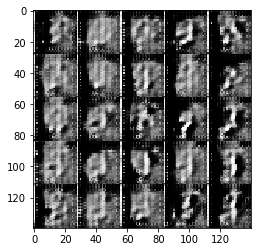

Epoch 1/2... Discriminator Loss: 0.3687... Generator Loss: 4.0666
Epoch 1/2... Discriminator Loss: 0.3929... Generator Loss: 3.3477
Epoch 1/2... Discriminator Loss: 0.3314... Generator Loss: 8.3551
Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 5.3023
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 4.7751
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 4.4471
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 5.2611
Epoch 1/2... Discriminator Loss: 0.3779... Generator Loss: 3.6678
Epoch 1/2... Discriminator Loss: 1.6187... Generator Loss: 3.6366
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 1.6901


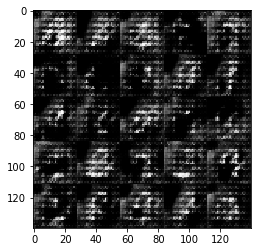

Epoch 1/2... Discriminator Loss: 2.7339... Generator Loss: 0.1456
Epoch 1/2... Discriminator Loss: 0.7125... Generator Loss: 1.4595
Epoch 1/2... Discriminator Loss: 0.8246... Generator Loss: 1.4742
Epoch 1/2... Discriminator Loss: 0.4639... Generator Loss: 2.6231
Epoch 1/2... Discriminator Loss: 0.5750... Generator Loss: 2.4482
Epoch 1/2... Discriminator Loss: 0.4347... Generator Loss: 2.6978
Epoch 1/2... Discriminator Loss: 0.3485... Generator Loss: 5.8753
Epoch 1/2... Discriminator Loss: 0.3738... Generator Loss: 4.1104
Epoch 1/2... Discriminator Loss: 0.3501... Generator Loss: 4.9251
Epoch 1/2... Discriminator Loss: 0.4616... Generator Loss: 3.9431


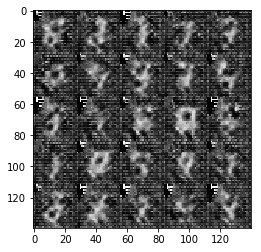

Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 5.4743
Epoch 1/2... Discriminator Loss: 0.7560... Generator Loss: 1.7749
Epoch 1/2... Discriminator Loss: 0.4165... Generator Loss: 3.8497
Epoch 1/2... Discriminator Loss: 1.6946... Generator Loss: 0.5915
Epoch 1/2... Discriminator Loss: 0.4287... Generator Loss: 3.2238
Epoch 1/2... Discriminator Loss: 0.4176... Generator Loss: 3.8668
Epoch 1/2... Discriminator Loss: 0.3503... Generator Loss: 5.2937
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 5.3640
Epoch 1/2... Discriminator Loss: 0.3466... Generator Loss: 5.4085


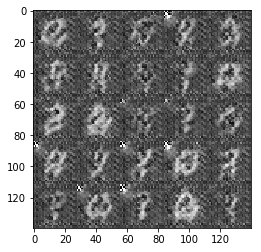

Epoch 1/2... Discriminator Loss: 0.3421... Generator Loss: 5.8028
Epoch 1/2... Discriminator Loss: 0.3368... Generator Loss: 7.0484
Epoch 1/2... Discriminator Loss: 0.3333... Generator Loss: 8.0937
Epoch 1/2... Discriminator Loss: 0.3339... Generator Loss: 6.6679
Epoch 1/2... Discriminator Loss: 0.4028... Generator Loss: 3.8068
Epoch 1/2... Discriminator Loss: 0.3488... Generator Loss: 5.8104
Epoch 1/2... Discriminator Loss: 1.5543... Generator Loss: 2.5818
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 2.6304
Epoch 1/2... Discriminator Loss: 0.9640... Generator Loss: 1.2620
Epoch 1/2... Discriminator Loss: 0.8588... Generator Loss: 1.4551


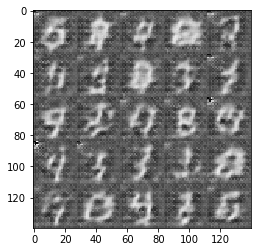

Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 3.8296
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 0.8101... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 8.4205... Generator Loss: 10.5976
Epoch 2/2... Discriminator Loss: 0.9787... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.0332... Generator Loss: 1.4354
Epoch 2/2... Discriminator Loss: 0.6199... Generator Loss: 1.8471
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 1.3409
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.4196


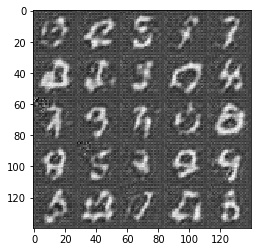

Epoch 2/2... Discriminator Loss: 0.6061... Generator Loss: 1.7252
Epoch 2/2... Discriminator Loss: 0.4850... Generator Loss: 2.5498
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 3.9851
Epoch 2/2... Discriminator Loss: 0.7929... Generator Loss: 1.4592
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 2.2312
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.3798
Epoch 2/2... Discriminator Loss: 0.4326... Generator Loss: 3.6547
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 2.9172
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 1.1400
Epoch 2/2... Discriminator Loss: 0.4857... Generator Loss: 3.2524


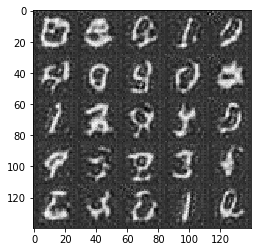

Epoch 2/2... Discriminator Loss: 0.4963... Generator Loss: 2.4841
Epoch 2/2... Discriminator Loss: 0.4885... Generator Loss: 2.7215
Epoch 2/2... Discriminator Loss: 0.8708... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 3.8505... Generator Loss: 0.0485
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.3312
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.5175
Epoch 2/2... Discriminator Loss: 0.9229... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 1.1390... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 0.8181... Generator Loss: 1.1123
Epoch 2/2... Discriminator Loss: 1.4440... Generator Loss: 0.4802


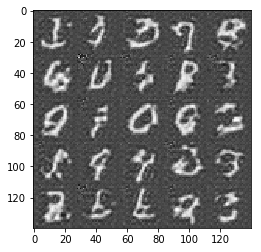

Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.2783
Epoch 2/2... Discriminator Loss: 0.7882... Generator Loss: 5.6106
Epoch 2/2... Discriminator Loss: 0.6108... Generator Loss: 1.6390
Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 1.2144
Epoch 2/2... Discriminator Loss: 1.0796... Generator Loss: 0.8686
Epoch 2/2... Discriminator Loss: 1.0092... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 1.4179... Generator Loss: 0.5262
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.5988
Epoch 2/2... Discriminator Loss: 0.8930... Generator Loss: 1.0167
Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 1.9766


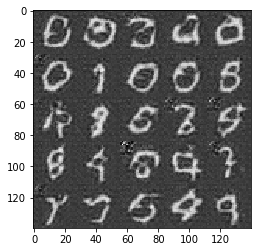

Epoch 2/2... Discriminator Loss: 0.6370... Generator Loss: 1.7194
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 1.8325
Epoch 2/2... Discriminator Loss: 0.5554... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 0.4822... Generator Loss: 2.6178
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.1274... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.2869
Epoch 2/2... Discriminator Loss: 0.8492... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 0.6062... Generator Loss: 1.7790
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 1.3448


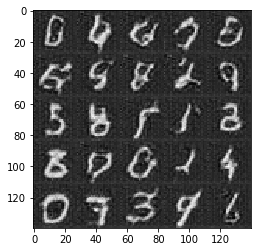

Epoch 2/2... Discriminator Loss: 0.9132... Generator Loss: 1.1917
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.1005
Epoch 2/2... Discriminator Loss: 1.5918... Generator Loss: 0.4757
Epoch 2/2... Discriminator Loss: 0.5630... Generator Loss: 3.3823
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 2.5549... Generator Loss: 0.2344
Epoch 2/2... Discriminator Loss: 1.0382... Generator Loss: 0.8269
Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 0.9103
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.6482
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.6151


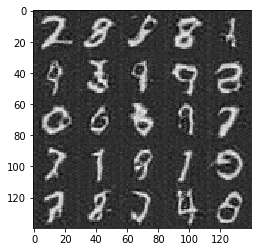

Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 2.3794
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 0.9029... Generator Loss: 1.5810
Epoch 2/2... Discriminator Loss: 2.0058... Generator Loss: 0.2799
Epoch 2/2... Discriminator Loss: 1.0247... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 0.7757... Generator Loss: 2.5494
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.2111
Epoch 2/2... Discriminator Loss: 0.5018... Generator Loss: 3.7562
Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 1.7662
Epoch 2/2... Discriminator Loss: 0.7598... Generator Loss: 1.8182


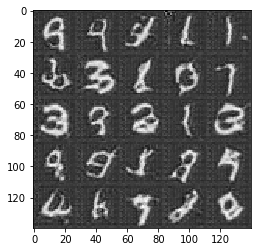

Epoch 2/2... Discriminator Loss: 0.6355... Generator Loss: 1.7544
Epoch 2/2... Discriminator Loss: 2.2462... Generator Loss: 0.2824
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.8230
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.7917
Epoch 2/2... Discriminator Loss: 0.6667... Generator Loss: 1.6522
Epoch 2/2... Discriminator Loss: 0.7136... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.7111... Generator Loss: 1.3771
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 1.9150
Epoch 2/2... Discriminator Loss: 0.3647... Generator Loss: 4.6503


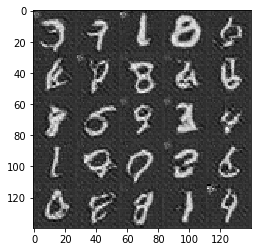

Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 1.7178
Epoch 2/2... Discriminator Loss: 0.3628... Generator Loss: 4.4298
Epoch 2/2... Discriminator Loss: 3.0749... Generator Loss: 0.0854
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.4494
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 0.4725... Generator Loss: 2.5506
Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 2.9782
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 3.1191
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 2.3255
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.8375


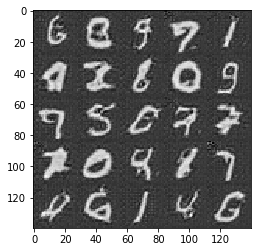

Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.3455
Epoch 2/2... Discriminator Loss: 0.5163... Generator Loss: 2.2612
Epoch 2/2... Discriminator Loss: 0.3770... Generator Loss: 3.5969
Epoch 2/2... Discriminator Loss: 0.4291... Generator Loss: 3.0851
Epoch 2/2... Discriminator Loss: 0.5170... Generator Loss: 2.1839
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.3918
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 1.3493


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 12.3635... Generator Loss: 0.0000


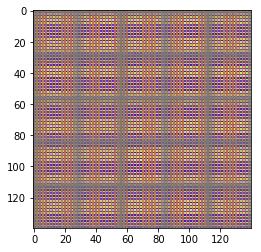

Epoch 1/1... Discriminator Loss: 0.5782... Generator Loss: 16.7122
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 5.7400
Epoch 1/1... Discriminator Loss: 0.3510... Generator Loss: 6.8819
Epoch 1/1... Discriminator Loss: 0.3328... Generator Loss: 5.9166
Epoch 1/1... Discriminator Loss: 0.3323... Generator Loss: 6.1009
Epoch 1/1... Discriminator Loss: 2.3939... Generator Loss: 2.5482
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 5.2752
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 1.7574
Epoch 1/1... Discriminator Loss: 0.4409... Generator Loss: 3.3274
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.2882


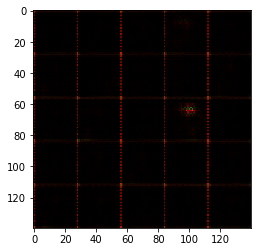

Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 2.4003
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 2.7603
Epoch 1/1... Discriminator Loss: 0.8371... Generator Loss: 1.5653
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 5.1983
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 1.2814
Epoch 1/1... Discriminator Loss: 0.5592... Generator Loss: 3.3262
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 3.4884
Epoch 1/1... Discriminator Loss: 0.5597... Generator Loss: 2.0584
Epoch 1/1... Discriminator Loss: 0.4868... Generator Loss: 3.8270
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 4.3061


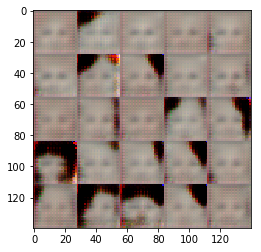

Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 2.2419
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.2048
Epoch 1/1... Discriminator Loss: 0.3977... Generator Loss: 3.1239
Epoch 1/1... Discriminator Loss: 0.4349... Generator Loss: 2.8562
Epoch 1/1... Discriminator Loss: 0.3929... Generator Loss: 4.2032
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.5566
Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.7308
Epoch 1/1... Discriminator Loss: 0.4126... Generator Loss: 2.8578
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.4588
Epoch 1/1... Discriminator Loss: 0.4134... Generator Loss: 3.6702


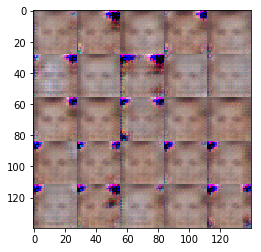

Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.8213
Epoch 1/1... Discriminator Loss: 0.3822... Generator Loss: 4.2147
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 4.5581
Epoch 1/1... Discriminator Loss: 0.4124... Generator Loss: 5.4700
Epoch 1/1... Discriminator Loss: 0.3949... Generator Loss: 3.2694
Epoch 1/1... Discriminator Loss: 0.3509... Generator Loss: 4.7695
Epoch 1/1... Discriminator Loss: 0.3833... Generator Loss: 4.3563
Epoch 1/1... Discriminator Loss: 2.0848... Generator Loss: 7.8407
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.9899
Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 2.7889


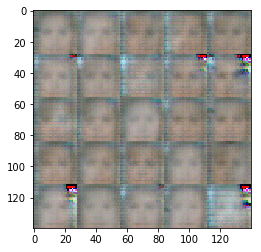

Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.8035
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.4030
Epoch 1/1... Discriminator Loss: 0.4074... Generator Loss: 3.2843
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 4.1352
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 3.5755
Epoch 1/1... Discriminator Loss: 0.3447... Generator Loss: 5.1723
Epoch 1/1... Discriminator Loss: 0.4251... Generator Loss: 3.0929
Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 3.5096
Epoch 1/1... Discriminator Loss: 1.9906... Generator Loss: 0.2846
Epoch 1/1... Discriminator Loss: 1.9607... Generator Loss: 0.8664


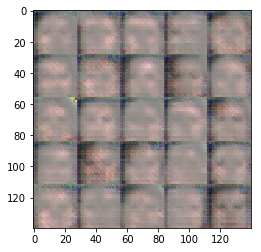

Epoch 1/1... Discriminator Loss: 1.8159... Generator Loss: 0.4610
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 2.0727... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 1.7941... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.9759... Generator Loss: 0.2737
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.4907... Generator Loss: 0.6480


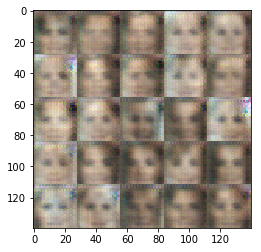

Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.6543... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 1.0542
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.0416... Generator Loss: 1.1891


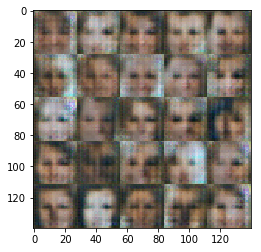

Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.7429... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.7238... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 1.9241
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.7193... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.8085


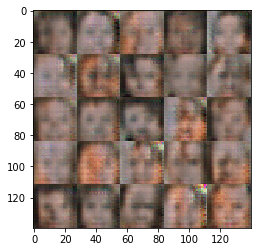

Epoch 1/1... Discriminator Loss: 1.7876... Generator Loss: 2.0122
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.8601
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.1076
Epoch 1/1... Discriminator Loss: 1.8389... Generator Loss: 0.2904
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 1.9121
Epoch 1/1... Discriminator Loss: 1.7531... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 2.1147
Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.4636


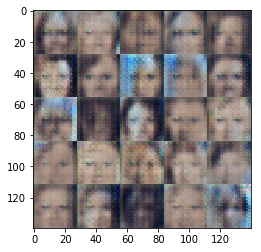

Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 2.5208
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 0.4381
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.3891
Epoch 1/1... Discriminator Loss: 3.2335... Generator Loss: 0.1262
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.6556


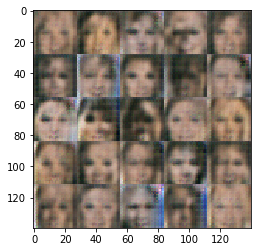

Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.9616... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 0.8872... Generator Loss: 1.6522
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.2206
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.2857
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.9026


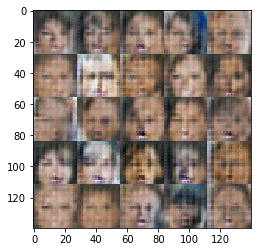

Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 1.1398
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.6177


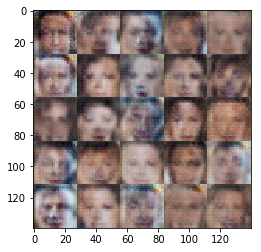

Epoch 1/1... Discriminator Loss: 1.8932... Generator Loss: 2.4675
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 1.7572... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 1.2791


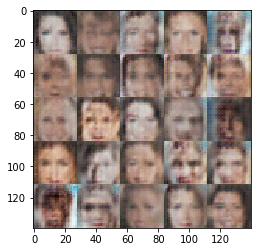

Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.8309


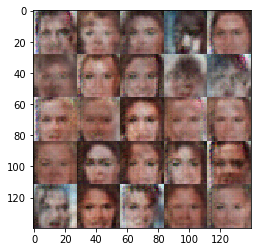

Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.9769
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.9631
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 1.1092


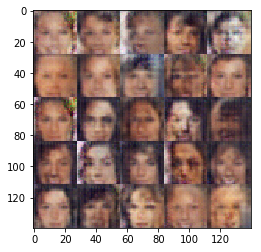

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.9287
Epoch 1/1... Discriminator Loss: 2.0868... Generator Loss: 2.3194
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 1.9469
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.0431


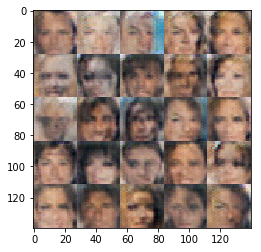

Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5659
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 1.0619
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.4813
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.1924


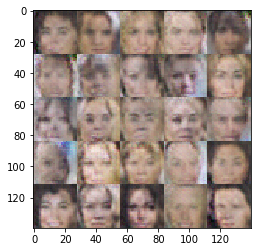

Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.5275
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5341


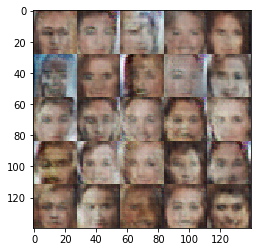

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.9914


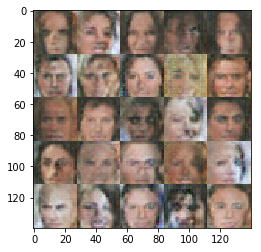

Epoch 1/1... Discriminator Loss: 1.6754... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.0476
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 1.0934... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7185


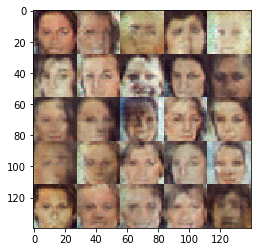

Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.9612
Epoch 1/1... Discriminator Loss: 1.6860... Generator Loss: 0.4866
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.9770


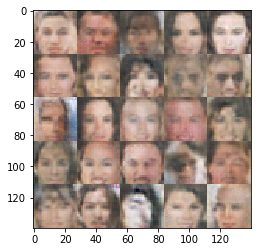

Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.8667
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 1.4085
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.9252
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.1530... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.6974... Generator Loss: 0.3972


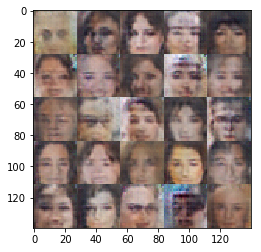

Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 2.5487
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 1.3245
Epoch 1/1... Discriminator Loss: 1.7132... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.8323... Generator Loss: 0.5521
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.6323


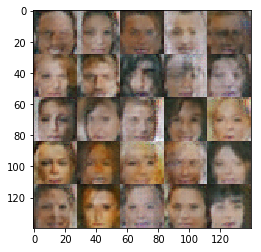

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.4442
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 2.2232
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 3.3201
Epoch 1/1... Discriminator Loss: 1.5704... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.9792


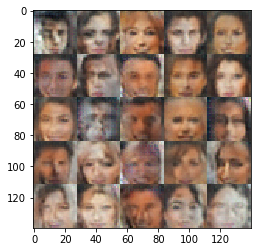

Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 2.0810
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.1593
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.1896
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.7883


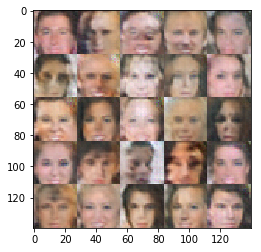

Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.1301
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.8605
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7005


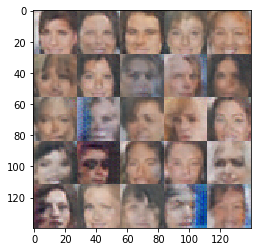

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9315
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.9252


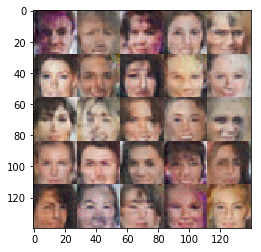

Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 1.6905
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.9277
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.4971... Generator Loss: 1.0070


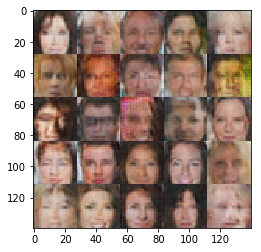

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 1.0179


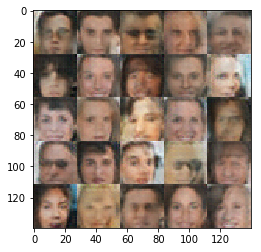

Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.6199... Generator Loss: 0.4424
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7828


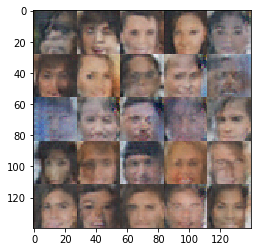

Epoch 1/1... Discriminator Loss: 1.5356... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.9748
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8235


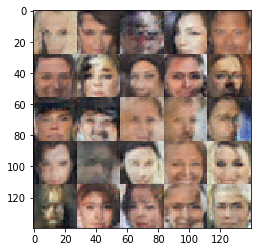

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9058


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.